In [1]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("glock", {}, "/glock/glock_person_anns/train.json", "/glock/glock_person_imgs")
register_coco_instances("glock_test", {}, "/glock/annotations_glock/test.json", "/glock/test")

from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 10000})

In [2]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [3]:
dataset_dicts = DatasetCatalog.get("glock")
glock_metadata = MetadataCatalog.get("glock")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [4]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/glock/glock_person_imgs/000000460722.jpg


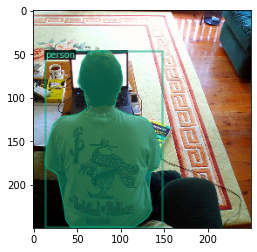

In [5]:
for d in random.sample(dataset_dicts, 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glock_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [6]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [7]:
from datetime import datetime
import os

In [8]:
cfg = get_cfg()

# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"./tboard_logs/glock_{datetime.now().isoformat().rsplit(':', 1)[0]}/"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("glock",)
cfg.DATASETS.TEST = ("glock_test",)

cfg.DATALOADER.NUM_WORKERS = 4

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"
'''
cfg.INPUT.MIN_SIZE_TRAIN = (256,)
cfg.INPUT.MIN_SIZE_TEST = (256,)
cfg.INPUT.MAX_SIZE_TRAIN = (1200,)
cfg.INPUT.MAX_SIZE_TEST = (1200,)
'''
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.NUM_CLASSES = 3
cfg.MODEL.BACKBONE.FREEZE_AT=3
# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 2 # 32
cfg.SOLVER.BASE_LR = 0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS = 1_000
cfg.SOLVER.GAMMA = 0.3
cfg.SOLVER.STEPS = (100_000, 200_000, 300_000, 400_000, 500_000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 100_000 
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(cfg.OUTPUT_DIR + "/config.yml", "w") as f:
    f.write(cfg.dump())

In [10]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[10/06 19:53:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[10/06 19:53:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[10/06 19:53:13 d2.data.datasets.coco]: Loading /glock/glock_person_anns/train.json takes 5.83 seconds.
WARNING [10/06 19:53:13 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/06 19:53:13 d2.data.datasets.coco]: Loaded 69970 images in COCO format from /glock/glock_person_anns/train.json
[10/06 19:53:16 d2.data.build]: Removed 0 images with no usable annotations. 69970 images left.
[10/06 19:53:18 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   person   | 257253       |   glock    | 3889         |   knife    | 7760     

model_final_f10217.pkl: 178MB [00:18, 9.61MB/s]                              


[10/06 19:53:38 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  ite

[10/06 19:53:44 d2.utils.events]:  eta: 0:20:29  iter: 19  total_loss: 0.725  loss_cls: 0.2208  loss_box_reg: 0.1165  loss_mask: 0.2761  loss_rpn_cls: 0.0242  loss_rpn_loc: 0.02513  time: 0.3100  data_time: 0.0160  lr: 1.9981e-05  max_mem: 2353M
[10/06 19:53:51 d2.utils.events]:  eta: 0:20:36  iter: 39  total_loss: 0.5712  loss_cls: 0.1959  loss_box_reg: 0.1053  loss_mask: 0.2078  loss_rpn_cls: 0.02217  loss_rpn_loc: 0.01783  time: 0.3193  data_time: 0.0193  lr: 3.9961e-05  max_mem: 2430M
[10/06 19:53:58 d2.utils.events]:  eta: 0:20:29  iter: 59  total_loss: 0.5237  loss_cls: 0.1556  loss_box_reg: 0.112  loss_mask: 0.2245  loss_rpn_cls: 0.02834  loss_rpn_loc: 0.01373  time: 0.3192  data_time: 0.0039  lr: 5.9941e-05  max_mem: 2458M
[10/06 19:54:04 d2.utils.events]:  eta: 0:20:31  iter: 79  total_loss: 0.6703  loss_cls: 0.1879  loss_box_reg: 0.1287  loss_mask: 0.2479  loss_rpn_cls: 0.02427  loss_rpn_loc: 0.01999  time: 0.3204  data_time: 0.0036  lr: 7.9921e-05  max_mem: 2464M
[10/06 19:5

[10/06 19:57:03 d2.utils.events]:  eta: 0:17:09  iter: 659  total_loss: 0.544  loss_cls: 0.1051  loss_box_reg: 0.1729  loss_mask: 0.2347  loss_rpn_cls: 0.02006  loss_rpn_loc: 0.03145  time: 0.3090  data_time: 0.0038  lr: 0.00065934  max_mem: 2940M
[10/06 19:57:10 d2.utils.events]:  eta: 0:17:04  iter: 679  total_loss: 0.5549  loss_cls: 0.1237  loss_box_reg: 0.1392  loss_mask: 0.2358  loss_rpn_cls: 0.01781  loss_rpn_loc: 0.01915  time: 0.3094  data_time: 0.0041  lr: 0.00067932  max_mem: 2940M
[10/06 19:57:16 d2.utils.events]:  eta: 0:16:59  iter: 699  total_loss: 0.3857  loss_cls: 0.06874  loss_box_reg: 0.1106  loss_mask: 0.1878  loss_rpn_cls: 0.01761  loss_rpn_loc: 0.01528  time: 0.3101  data_time: 0.0042  lr: 0.0006993  max_mem: 2940M
[10/06 19:57:22 d2.utils.events]:  eta: 0:16:52  iter: 719  total_loss: 0.4282  loss_cls: 0.08683  loss_box_reg: 0.09266  loss_mask: 0.1933  loss_rpn_cls: 0.01513  loss_rpn_loc: 0.01158  time: 0.3099  data_time: 0.0035  lr: 0.00071928  max_mem: 2940M
[10

[10/06 20:00:16 d2.utils.events]:  eta: 0:13:33  iter: 1299  total_loss: 0.4412  loss_cls: 0.07042  loss_box_reg: 0.1014  loss_mask: 0.2036  loss_rpn_cls: 0.004765  loss_rpn_loc: 0.008527  time: 0.3054  data_time: 0.0041  lr: 0.001  max_mem: 2940M
[10/06 20:00:23 d2.utils.events]:  eta: 0:13:27  iter: 1319  total_loss: 0.4801  loss_cls: 0.08227  loss_box_reg: 0.1562  loss_mask: 0.2269  loss_rpn_cls: 0.01224  loss_rpn_loc: 0.02279  time: 0.3056  data_time: 0.0038  lr: 0.001  max_mem: 2940M
[10/06 20:00:29 d2.utils.events]:  eta: 0:13:22  iter: 1339  total_loss: 0.5075  loss_cls: 0.08832  loss_box_reg: 0.15  loss_mask: 0.2521  loss_rpn_cls: 0.01126  loss_rpn_loc: 0.01606  time: 0.3056  data_time: 0.0040  lr: 0.001  max_mem: 2940M
[10/06 20:00:35 d2.utils.events]:  eta: 0:13:14  iter: 1359  total_loss: 0.4884  loss_cls: 0.07111  loss_box_reg: 0.08061  loss_mask: 0.2423  loss_rpn_cls: 0.01037  loss_rpn_loc: 0.02536  time: 0.3053  data_time: 0.0037  lr: 0.001  max_mem: 2940M
[10/06 20:00:41

[10/06 20:03:41 d2.utils.events]:  eta: 0:10:19  iter: 1959  total_loss: 0.4732  loss_cls: 0.07463  loss_box_reg: 0.09476  loss_mask: 0.2155  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.01333  time: 0.3065  data_time: 0.0040  lr: 0.001  max_mem: 2940M
[10/06 20:03:47 d2.utils.events]:  eta: 0:10:13  iter: 1979  total_loss: 0.4326  loss_cls: 0.05794  loss_box_reg: 0.09231  loss_mask: 0.217  loss_rpn_cls: 0.01883  loss_rpn_loc: 0.01867  time: 0.3064  data_time: 0.0041  lr: 0.001  max_mem: 2940M
[10/06 20:03:53 d2.utils.events]:  eta: 0:10:07  iter: 1999  total_loss: 0.6348  loss_cls: 0.116  loss_box_reg: 0.2026  loss_mask: 0.2458  loss_rpn_cls: 0.008648  loss_rpn_loc: 0.02315  time: 0.3066  data_time: 0.0042  lr: 0.001  max_mem: 2940M
[10/06 20:03:59 d2.utils.events]:  eta: 0:10:01  iter: 2019  total_loss: 0.5948  loss_cls: 0.09488  loss_box_reg: 0.1552  loss_mask: 0.2466  loss_rpn_cls: 0.01144  loss_rpn_loc: 0.02191  time: 0.3066  data_time: 0.0041  lr: 0.001  max_mem: 2940M
[10/06 20:04:05 

KeyboardInterrupt: 

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("glock_test")
glock_test_metadata = MetadataCatalog.get("glock_test")

In [ ]:
smpl = np.random.choice(test_dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_test_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(test_dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_test_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/klocki"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())